In [ ]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
!pip install hmmlearn
from hmmlearn import hmm
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
PLOT_SHOW=True
PLOT_TYPE = False

In [ ]:
NUM_TEST = 90
K = 50
NUM_ITERS=10000

In [ ]:
labels = ['Close','Open','High','Low','Volume']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

In [ ]:
# Possible number of states in Markov Model
STATE_SPACE = range(2,25)

In [ ]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [ ]:
stock = '/content/gdrive/MyDrive/Colab Notebooks/batbc.txt'
dataset_tmp = np.genfromtxt(stock, delimiter=',')
dataset = dataset_tmp[~np.isnan(dataset_tmp).any(axis=1)]

In [ ]:
predicted_stock_data = np.empty([0,dataset.shape[1]])
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

In [ ]:
for states in STATE_SPACE:
    num_params = states**2 + states
    model = hmm.GaussianHMM(n_components=states, covariance_type='diag', tol=0.0001, n_iter=NUM_ITERS)
    model.fit(dataset[NUM_TEST:,:])
    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
    bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))

In [ ]:
opt_states = np.argmin(bic_vect) + 2
print('Optimum number of states are {}'.format(opt_states))

Optimum number of states are 23


In [ ]:
for idx in reversed(range(NUM_TEST)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='diag', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='diag', tol=0.0001, n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = np.array([np.diag(i) for i in model.covars_])

    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    
    print(idx)
    iters = 1;
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [ ]:
np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

MAPE for the stock /content/gdrive/MyDrive/Colab Notebooks/batbc.txt is  [0.02700062 0.03409031 0.02975671 0.02505885 0.71677793]


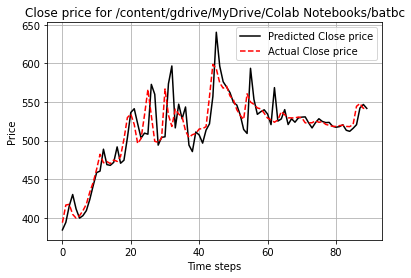

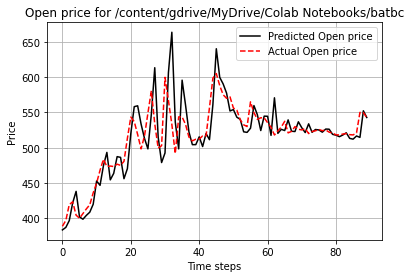

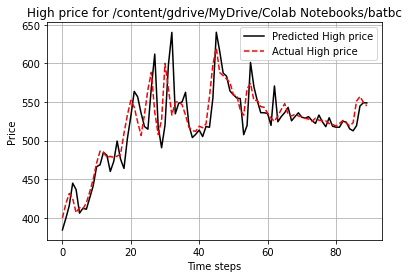

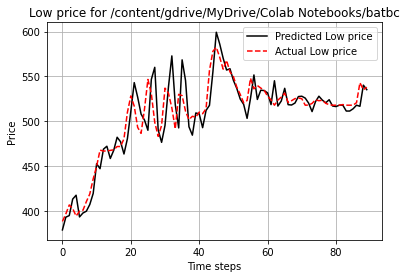

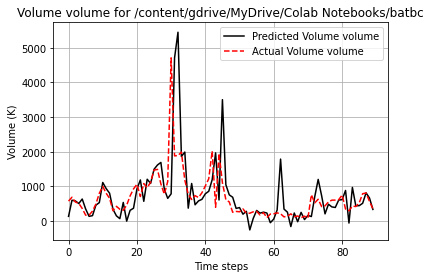

In [ ]:
mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(90),:]))
print('MAPE for the stock {} is '.format(stock),mape)

if PLOT_TYPE:
    hdl_p = plt.plot(range(90), predicted_stock_data);
    plt.title('Predicted stock prices/volume')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low','Volume'))
    plt.xlabel('Time steps')
    plt.ylabel('Price/Volume')
    plt.figure()
    hdl_a = plt.plot(range(90),np.flipud(dataset[range(90),:]))
    plt.title('Actual stock prices/volume')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low','Volume'))
    plt.xlabel('Time steps')
    plt.ylabel('Price/Volume')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(90), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
        plt.plot(range(90),np.flipud(dataset[range(90),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper right')

    plt.figure()
    plt.plot(range(90), predicted_stock_data[:,4],'k-', label = 'Predicted '+labels[4]+' volume');
    plt.plot(range(90),np.flipud(dataset[range(90),4]),'r--', label = 'Actual '+labels[4]+' volume')
    plt.xlabel('Time steps')
    plt.ylabel('Volume (K)')
    plt.title(labels[4]+' volume'+ ' for '+stock[:-4])
    plt.grid(True)
    plt.legend(loc = 'upper right')
    

if PLOT_SHOW:
    plt.show(block=False)